In [30]:
import pandas as pd
import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2
from matplotlib_venn import venn3, venn3_unweighted
import venn

In [41]:
pd.set_option('display.max_columns', None)

In [31]:
def get_reverse(nucleotyde):
    nucleotyde = str(nucleotyde)
    nucleotyde_rev = {'A' : 'T',
                     'T' : 'A',
                     'C' : 'G',
                     'G': 'C'}
    if len(nucleotyde) > 1:
        nucleotyde_str = nucleotyde[::-1] #Reverse nucleotide
        nucleotyde_str_fin = "".join([nucleotyde_rev[x] for x in nucleotyde_str]) #Complement nucleotide
        return nucleotyde_str_fin
    else:
        return nucleotyde_rev[nucleotyde]

In [32]:
print(get_reverse('AG'))

CT


# Declare files

In [33]:
vcf_res = "MTB_Base_Calibration_List.vcf"
phyres = "201907/nph-phyresse_v29.xlsx"
ptt = "../genes/H37Rv_annotation2sytems.ptt"
megalist = "201907/Resistance_Report_v2019-01.xlsx"
genbank = "../genes/Gene_list_from_genbank_v2.tsv"
#extended_res = "MTB_Extended_Resistance_Mediating.txt"


In [5]:
def extract_nuchange(row):
    if ">" in row.nuchange:
        nuchange_split = re.findall(r'(^[-]?\d*.*\d)([ATCG]+)>([ATCG]+)', row.nuchange)[0]
        if len(nuchange_split) == 3:
            return nuchange_split
        else:
            return ('Nan', 'NaN', 'NaN')

In [6]:
def extract_snp(row):
    if ">" in row.nuchange:
        return "snp" + ',' + "test"

In [7]:
"""
def import_megatable(megatable):
    df = pd.read_excel(megatable, skiprows=1)
    for index, data_row in df.iterrows():
        if ">" in df.loc[index,'nuchange']:
            nuchange_split = re.findall(r'(^[-]?\d*.*\d)([ATCG]+)>([ATCG]+)', df.loc[index,'nuchange'])[0]
            if len(nuchange_split) == 3:
                gene_pos, REF, ALT = nuchange_split
                df.loc[index, 'gene_pos'] = gene_pos
                df.loc[index, 'REF'] = REF
                df.loc[index, 'ALT'] = ALT
    #df[['gene_pos','REF', 'ALT']] = df.apply(extract_nuchange, axis=1).str.split(',', expand=True)
    #df[['gene_pos','REF']] = df.apply(extract_snp, axis=1).str.split(',', expand=True)
    #dataframe[['gene_pos','REF']] = dataframe['tmp'].values.str.split(',', expand=True)
    #dataframe['len'] = dataframe['tmp'].str.len()
    return df
"""

'\ndef import_megatable(megatable):\n    df = pd.read_excel(megatable, skiprows=1)\n    for index, data_row in df.iterrows():\n        if ">" in df.loc[index,\'nuchange\']:\n            nuchange_split = re.findall(r\'(^[-]?\\d*.*\\d)([ATCG]+)>([ATCG]+)\', df.loc[index,\'nuchange\'])[0]\n            if len(nuchange_split) == 3:\n                gene_pos, REF, ALT = nuchange_split\n                df.loc[index, \'gene_pos\'] = gene_pos\n                df.loc[index, \'REF\'] = REF\n                df.loc[index, \'ALT\'] = ALT\n    #df[[\'gene_pos\',\'REF\', \'ALT\']] = df.apply(extract_nuchange, axis=1).str.split(\',\', expand=True)\n    #df[[\'gene_pos\',\'REF\']] = df.apply(extract_snp, axis=1).str.split(\',\', expand=True)\n    #dataframe[[\'gene_pos\',\'REF\']] = dataframe[\'tmp\'].values.str.split(\',\', expand=True)\n    #dataframe[\'len\'] = dataframe[\'tmp\'].str.len()\n    return df\n'

In [8]:
def import_megatable(megatable):
    df = pd.read_excel(megatable, skiprows=1)
    
    df['tmp'] = df.apply(extract_nuchange, axis=1)
    df = df[df.tmp.notnull()]
    #SPLIT TUPLES INTO COLUMNS!!!!!!!!!!
    df[['gene_pos','REF', 'ALT']] = pd.DataFrame(df.tmp.values.tolist(), index= df.index)
    df.drop('tmp', axis=1, inplace=True)
    df[['Gene','is_upstream']]=df.gene.str.split(' ', expand=True)
    df.gene_pos = df.gene_pos.astype(int)
    df.confidence_upp = df.confidence_upp.astype(str)
    #df['tmp2'] = list(df.tmp).str.split(expand=True)
    #df[['gene_pos','REF', 'ALT']] = df.tmp.str[0:].str.split( expand=True)
    #df['stats'].str[1:-1].str.split(',', expand=True).astype(float)
    return df

In [9]:
def import_phyres(phyres):
    df = pd.read_excel(phyres, sep='\t', header=0)
    
    df['ALT']=df['Var. base'].str.upper()
    df['REF']=df['WT base'].str.upper()
    df.rename(columns={'#Variant position genome start':'POS'}, inplace=True)
    df['High Confidence SNP'].fillna("no", inplace=True)
    df['POSALT'] = df['POS'].astype(str) + df['ALT']
    df = df[df['Var. type'] == 'SNP'] #Remove INDELS
    df['Isreverse'] = df['Gene ID'].apply(lambda x: True if x.endswith("c") else False)
    
    
    return df

In [10]:
def import_VCF41_to_pandas(vcf_file):
    header_lines = 0
    with open(vcf_file) as f:
        first_line = f.readline().strip()
        next_line = f.readline().strip()
        while next_line.startswith("##"):
            header_lines = header_lines + 1
            #print(next_line)
            next_line = f.readline()

    if first_line.endswith('VCFv4.1'):
        df = pd.read_csv(vcf_file, sep='\t', skiprows=[header_lines], header=header_lines)
        
        for index, _ in df.iterrows():
            info_fields = re.findall(r';*([a-zA-Z]{1,20})=', df.loc[index,'INFO'])
            info_values = re.sub(r'([a-zA-Z]{1,20})=', '', df.loc[index,'INFO']).split(";") #Remove fields and split the remaining
        
            for ifield, ivalue in zip(info_fields,info_values):
                df.loc[index,ifield] = ivalue
        
        df = df[(~df['RES'].str.startswith("phylo"))] #Remove phylo(lineage) markers
        df['ALT']=df['ALT'].str.upper()
        df['REF']=df['REF'].str.upper()
        df[['Gene ID', 'Gene name', 'Gene start', 'Gene stop']] = df.GENE.str.split(":", expand=True)
        #df['GENE'] = df['INFO'].apply(lambda x: extract_gene_name(x))
        df['Isreverse'] = df['Gene ID'].apply(lambda x: True if x.endswith("c") else False)
        
        df['POSALT'] = df['POS'].astype(str) + df['ALT']
        
        return df
    else:
        print("This vcf file is not v4.1")
        sys.exit(1)

# Import files

In [11]:
mega_df = import_megatable(megalist)
ptt_df = pd.read_csv(ptt, sep='\t', skiprows=2)
vcf_res_df = import_VCF41_to_pandas(vcf_res)
phyres_df = import_phyres(phyres)
genbank_df = pd.read_csv(genbank, sep='\t', names=['Gene','Gene_id','start','end','strand'])

In [12]:
mega_df.head(2)

,drug,gene,iso_tested,iso_w_mut,iso_excluded,denominator,nuchange,aachange,TP,FP,...,p-value,confidence_low,confidence_upp,Bonferroni_adjusted,FDR_adjusted,gene_pos,REF,ALT,Gene,is_upstream
0,AMIKACIN,rrs,1229,3,3,1226,1050C>T,NaN,2,1,...,0.158321,0.46552,inf,1.0,0.803966,1050,C,T,rrs,None
1,AMIKACIN,rrs,1229,1,3,1226,1125C>T,NaN,0,1,...,0.747961,0.00000,56.215319,1.0,0.803966,1125,C,T,rrs,None


In [13]:
ptt_df.head(2)

,Location,Strand,Length,PID,lenght,Unnamed: 5,Gene,Synonym,COG,sanger_anot,Possible DR/phage/PEPPE?,essential?,Annotation
0,1..1524,1,1524,+,507.0,15607143.0,dnaA,Rv0001,COG0593L,II.A.5,NaN,essential,chromosomal replication initiation protein
1,1525..2051,1525,2051,I,NaN,NaN,NaN,IG1_Rv0001-Rv0002,NaN,NaN,NaN,NaN,NaN


In [14]:
vcf_res_df.head(2)

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,REG,SVTYPE,GENE,AMINO,RES,Gene ID,Gene name,Gene start,Gene stop,Isreverse,POSALT
0,MTB_anc,6575,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485Cys,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6575T
1,MTB_anc,6576,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485His,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6576A


In [15]:
phyres_df.head(2)

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,...,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,ALT,REF,POSALT,Isreverse
0,6575,6575,SNP,1,c,t,coding,Rv0005,gyrB,5240,...,cgt/tgt,1336,1336,fluoroquinolones (FQ),19470506,no,T,C,6575T,False
1,6620,6620,SNP,1,g,c,coding,Rv0005,gyrB,5240,...,gac/cac,1381,1381,fluoroquinolones (FQ),24055765,yes,C,G,6620C,False


In [16]:
genbank_df.head()

,Gene,Gene_id,start,end,strand
0,dnaA,Rv0001,0,1524,+
1,dnaN,Rv0002,2051,3260,+
2,recF,Rv0003,3279,4437,+
3,Rv0004,Rv0004,4433,4997,+
4,gyrB,Rv0005,5239,7267,+


# TEST GROUPING !!

In [115]:
mega_df_by_grug = mega_df.groupby('drug')

In [120]:
type(mega_df_by_grug)

pandas.core.groupby.generic.DataFrameGroupBy

In [121]:
mega_df_by_grug.describe()

/home/laura/env36/lib/python3.6/site-packages/numpy/lib/function_base.py:3942: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


iso_tested                                                       \
                  count    mean  std     min     25%     50%     75%     max   
drug                                                                           
AMIKACIN           85.0  1229.0  0.0  1229.0  1229.0  1229.0  1229.0  1229.0   
CAPREOMYCIN        62.0   808.0  0.0   808.0   808.0   808.0   808.0   808.0   
CYCLOSERINE        30.0   216.0  0.0   216.0   216.0   216.0   216.0   216.0   
ETHAMBUTOL        629.0  2384.0  0.0  2384.0  2384.0  2384.0  2384.0  2384.0   
ETHIONAMIDE       338.0   951.0  0.0   951.0   951.0   951.0   951.0   951.0   
ISONIAZID         862.0  2830.0  0.0  2830.0  2830.0  2830.0  2830.0  2830.0   
KANAMYCIN          81.0   975.0  0.0   975.0   975.0   975.0   975.0   975.0   
LEVOFLOXACIN       75.0   368.0  0.0   368.0   368.0   368.0   368.0   368.0   
LINEZOLID           2.0    27.0  0.0    27.0    27.0    27.0    27.0    27.0   
MOXIFLOXACIN      108.0   525.0  0.0   525.0   525.0   525.0   525.0   525.0   
OFLOXACIN         251.0  1317.0  0.0  1317.0  1317.0  1317.0  1317.0  1317.0   
PYRAZINAMIDE     1219.0  2196.0  0.0  2196.0  2196.0  2196.0  2196.0  2196.0   
RIFABUTIN         162.0   220.0  0.0   220.0   220.0   220.0   220.0   220.0   
RIFAMPICIN        660.0  2930.0  0.0  2930.0  2930.0  2930.0  2930.0  2930.0   
STREPTOMYCIN      346.0  1818.0  0.0  1818.0  1818.0  1818.0  1818.0  1818.0   

             iso_w_mut             ... FDR_adjusted           gene_pos  \
                 count       mean  ...          75%       max    count   
drug                               ...                                   
AMIKACIN          85.0   7.611765  ...     0.803966  0.803966     85.0   
CAPREOMYCIN       62.0  18.451613  ...     0.832278  1.000000     62.0   
CYCLOSERINE       30.0  30.766667  ...     0.803966  1.000000     30.0   
ETHAMBUTOL       629.0  22.187599  ...     0.803966  0.803966    629.0   
ETHIONAMIDE      338.0   9.792899  ...     0.803966  0.803966    338.0   
ISONIAZID        862.0  11.877030  ...     0.803966  0.803966    862.0   
KANAMYCIN         81.0   7.197531  ...     0.803966  0.803966     81.0   
LEVOFLOXACIN      75.0  22.280000  ...     0.943364  1.000000     75.0   
LINEZOLID          2.0   1.500000  ...          NaN       NaN      2.0   
MOXIFLOXACIN     108.0  23.638889  ...     0.961417  1.000000    108.0   
OFLOXACIN        251.0  26.394422  ...     0.803966  1.000000    251.0   
PYRAZINAMIDE    1219.0  12.563577  ...     0.803966  0.804126   1219.0   
RIFABUTIN        162.0   5.537037  ...     0.803966  0.803966    162.0   
RIFAMPICIN       660.0  17.930303  ...     0.803966  0.803966    660.0   
STREPTOMYCIN     346.0  15.893064  ...     0.803966  0.803966    346.0   

                                                                         \
                     mean          std     min     25%     50%      75%   
drug                                                                      
AMIKACIN       717.894118   432.953314   -92.0  358.00   712.0  1050.00   
CAPREOMYCIN    944.467742   780.790829  -219.0  348.00   785.5  1401.75   
CYCLOSERINE    441.600000   542.946978  -274.0  -51.50   361.5   958.75   
ETHAMBUTOL    1211.709062   920.461987  -287.0  458.00  1040.0  1823.00   
ETHIONAMIDE    563.260355   437.216469   -94.0  188.75   497.0   931.25   
ISONIAZID      577.132251   512.780602  -243.0  157.25   497.5   858.50   
KANAMYCIN      419.135802   523.382264  -350.0  -10.00   213.0   887.00   
LEVOFLOXACIN  1172.346667   975.005454  -180.0  336.00   905.0  1539.50   
LINEZOLID      597.500000   543.765115   213.0  405.25   597.5   789.75   
MOXIFLOXACIN  1318.888889  1076.169551  -180.0  296.00  1172.0  1982.25   
OFLOXACIN     1260.183267   971.414662  -237.0  468.00  1167.0  1860.50   
PYRAZINAMIDE  1579.168991  1853.419016 -1707.0  212.00   811.0  2688.00   
RIFABUTIN     1267.746914  1062.719980  -409.0  381.00  1013.5  1859.25   
RIFAMPICIN    1411.215152  1053.313461 

In [127]:
#The grouped DF is a list with the group and the dataframe values for that category 
#list(mega_df_by_grug)[2]

In [129]:
mega_df_mean_by_drug = mega_df_by_grug.mean()

In [161]:
phyres_df['Antibiotic'] = phyres_df['Antibiotic'].astype('category')
phyres_df['Gene ID'] = phyres_df['Gene ID'].astype('category')
phyres_df_idx2 = phyres_df.set_index(['Antibiotic', 'Gene ID'])

In [162]:
phyres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 24 columns):
#Variant position genome start    613 non-null int64
Variant position genome stop      613 non-null object
Var. type                         613 non-null object
Number                            613 non-null int64
WT base                           613 non-null object
Var. base                         613 non-null object
Region                            613 non-null object
Gene ID                           613 non-null category
Gene Name                         613 non-null object
Gene start                        613 non-null int64
Gene stop                         613 non-null int64
Gene length                       613 non-null int64
Dir.                              613 non-null object
WT AA                             613 non-null object
Codon nr.                         613 non-null object
Codon nr. E. coli                 612 non-null object
Var. AA                           

In [163]:
phyres_df_idx2.head()

#Variant position genome start  \
Antibiotic            Gene ID                                   
fluoroquinolones (FQ) Rv0005                             6575   
                      Rv0005                             6620   
                      Rv0005                             6620   
                      Rv0005                             6621   
                      Rv0005                             6734   

                              Variant position genome stop Var. type  Number  \
Antibiotic            Gene ID                                                  
fluoroquinolones (FQ) Rv0005                          6575       SNP       1   
                      Rv0005                          6620       SNP       1   
                      Rv0005                          6620       SNP       1   
                      Rv0005                          6621       SNP       1   
                      Rv0005                          6734       SNP       1   

                              WT base Var. base  Region Gene Name  Gene start  \
Antibiotic            Gene ID                                                   
fluoroquinolones (FQ) Rv0005        c         t  coding      gyrB        5240   
                      Rv0005        g         c  coding      gyrB        5240   
                      Rv0005        g         a  coding      gyrB        5240   
                      Rv0005        a         c  coding      gyrB        5240   
                      Rv0005        a         g  coding      gyrB        5240   

                               Gene stop  ...  WT AA Codon nr.  \
Antibiotic            Gene ID             ...                    
fluoroquinolones (FQ) Rv0005        7267  ...    Arg       446   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asn       499   

                              Codon nr. E. coli Var. AA  AA change  \
Antibiotic            Gene ID                                        
fluoroquinolones (FQ) Rv0005                  -     Cys  Arg446Cys   
                      Rv0005                  -     His  Asp461His   
                      Rv0005                  -     Asn  Asp461Asn   
                      Rv0005                  -     Ala  Asp461Ala   
                      Rv0005                  -     Asp  Asn499Asp   

                              Codon change Variant position gene start  \
Antibiotic            Gene ID                                            
fluoroquinolones (FQ) Rv0005       cgt/tgt                        1336   
                      Rv0005       gac/cac                        1381   
                      Rv0005       gac/aac                        1381   
                      Rv0005       gac/gcc                        1382   
                      Rv0005       aac/gac                        1495   

                              Variant position gene stop  Reference PMID  \
Antibiotic            Gene ID                                              
fluoroquinolones (FQ) Rv0005                        1336        19470506   
                      Rv0005                        1381        24055765   
                      Rv0005                        1381        19721073   
                      Rv0005                        1382        24055765   
                      Rv0005                        1495        17412727   

                               High Confidence SNP  
Antibiotic            Gene ID                       
fluoroquinolones (FQ) Rv0005                   NaN  
                      Rv0005                   yes  
                      Rv0005                   yes  
                      Rv0005                   yes  
                      Rv0005                   yes  

[5 rows x 22 columns]

In [307]:
phyres_df_idx2.loc[("fluoroquinolones (FQ)", 'Rv0005')]

/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


#Variant position genome start  \
Antibiotic            Gene ID                                   
fluoroquinolones (FQ) Rv0005                             6575   
                      Rv0005                             6620   
                      Rv0005                             6620   
                      Rv0005                             6621   
                      Rv0005                             6734   
                      Rv0005                             6735   
                      Rv0005                             6736   
                      Rv0005                             6737   
                      Rv0005                             6738   
                      Rv0005                             6741   
                      Rv0005                             6742   
                      Rv0005                             6749   
                      Rv0005                             6750   

                              Variant position genome stop Var. type  Number  \
Antibiotic            Gene ID                                                  
fluoroquinolones (FQ) Rv0005                          6575       SNP       1   
                      Rv0005                          6620       SNP       1   
                      Rv0005                          6620       SNP       1   
                      Rv0005                          6621       SNP       1   
                      Rv0005                          6734       SNP       1   
                      Rv0005                          6735       SNP       1   
                      Rv0005                          6736       SNP       1   
                      Rv0005                          6737       SNP       1   
                      Rv0005                          6738       SNP       1   
                      Rv0005                          6741       SNP       1   
                      Rv0005                          6742       SNP       1   
                      Rv0005                          6749       SNP       1   
                      Rv0005                          6750       SNP       1   

                              WT base Var. base  Region Gene Name  Gene start  \
Antibiotic            Gene ID                                                   
fluoroquinolones (FQ) Rv0005        c         t  coding      gyrB        5240   
                      Rv0005        g         c  coding      gyrB        5240   
                      Rv0005        g         a  coding      gyrB        5240   
                      Rv0005        a         c  coding      gyrB        5240   
                      Rv0005        a         g  coding      gyrB        5240   
                      Rv0005        a         c  coding      gyrB        5240   
                      Rv0005        c         g  coding      gyrB        5240   
                      Rv0005        a         c  coding      gyrB        5240   
                      Rv0005        c         a  coding      gyrB        5240   
                      Rv0005        a         t  coding      gyrB        5240   
                      Rv0005        a         t  coding      gyrB        5240   
                      Rv0005        g         a  coding      gyrB        5240   
                      Rv0005        c         t  coding      gyrB        5240   

                               Gene stop  ...  WT AA Codon nr.  \
Antibiotic            Gene ID             ...                    
fluoroquinolones (FQ) Rv0005        7267  ...    Arg       446   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asp       461   
                      Rv0005        7267  ...    Asn       499   
                      Rv0005        7267  ...    Asn       499   
                      Rv0005        7267  ...    Asn       499   
                      Rv0005        7267  ..

In [171]:
phyres_df_idx2.groupby(['Antibiotic', 'Gene ID']).size().head(20)

Antibiotic                                        Gene ID
amikacin (AMK) kanamycin (KAN) capreomycin (CPR)  Rvnr01      3
capreomycin (CPR)                                 Rv1694     15
ethambutol (EMB)                                  Rv3793      1
                                                  Rv3794      9
                                                  Rv3795     26
ethionamide (ETH)                                 Rv0486      6
                                                  Rv3854c    16
fluoroquinolones (FQ)                             Rv0005     13
                                                  Rv0006     11
isoniazid (INH)                                   Rv1483      5
                                                  Rv1908c    12
                                                  Rv2428      2
isoniazid (INH) ethionamide (ETH)                 Rv1484      2
                                                  Rv1854c     2
kanamycin (KAN)                               

In [141]:
#phyres_df_idx2.index

In [112]:
phyres_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613 entries, 0 to 612
Data columns (total 24 columns):
#Variant position genome start    613 non-null int64
Variant position genome stop      613 non-null object
Var. type                         613 non-null object
Number                            613 non-null int64
WT base                           613 non-null object
Var. base                         613 non-null object
Region                            613 non-null object
Gene ID                           613 non-null object
Gene Name                         613 non-null object
Gene start                        613 non-null int64
Gene stop                         613 non-null int64
Gene length                       613 non-null int64
Dir.                              613 non-null object
WT AA                             613 non-null object
Codon nr.                         613 non-null object
Codon nr. E. coli                 612 non-null object
Var. AA                           61

In [113]:
phyres_df.describe()

,#Variant position genome start,Number,Gene start,Gene stop,Gene length,Variant position gene start,Variant position gene stop,Reference PMID
count,6.130000e+02,613.000000,6.130000e+02,6.130000e+02,613.000000,613.000000,613.000000,6.130000e+02
mean,2.268605e+06,1.016313,2.268344e+06,2.268941e+06,1492.507341,666.008157,666.014682,2.132797e+07
std,1.281537e+06,0.267636,1.281636e+06,1.281450e+06,1123.483343,663.388059,663.394434,5.389977e+06
min,5.520000e+03,1.000000,5.240000e+03,7.267000e+03,246.000000,-102.000000,-102.000000,7.540819e+06
25%,1.472750e+06,1.000000,1.471846e+06,1.473382e+06,561.000000,207.000000,207.000000,1.972107e+07
50%,2.288887e+06,1.000000,2.289241e+06,2.288681e+06,1011.000000,425.000000,425.000000,2.405576e+07
75%,2.940461e+06,1.000000,2.940612e+06,2.939959e+06,2223.000000,991.000000,991.000000,2.517604e+07
max,4.408213e+06,7.000000,4.408202e+06,4.407528e+06,6381.000000,5787.000000,5787.000000,2.533646e+07


# END OF TEST GROUPING !!

# Create a df with only gene names and rename columns

In [13]:
ptt_df = ptt_df[ptt_df.Gene.notnull()]
ptt_df.reset_index(inplace=True)
ptt_df.rename(columns={"Strand":'start', "Length":'end', "PID":'strand'}, inplace=True)
ptt_df = ptt_df[['start', 'end', 'strand', 'Gene']]

In [14]:
ptt_df.head()

,start,end,strand,Gene
0,1,1524,+,dnaA
1,2052,3260,+,dnaN
2,3280,4437,+,recF
3,4434,4997,+,-
4,5123,7267,+,gyrB


In [15]:
ptt_df.shape

(3989, 4)

In [16]:
genbank_df.head(5)

,Gene,Gene_id,start,end,strand
0,dnaA,Rv0001,0,1524,+
1,dnaN,Rv0002,2051,3260,+
2,recF,Rv0003,3279,4437,+
3,Rv0004,Rv0004,4433,4997,+
4,gyrB,Rv0005,5239,7267,+


# Add +1 to start positions so it adapts to standard (Fasta sequences and other files) !!! ################

In [17]:
genbank_df = pd.read_csv(genbank, sep='\t', names=['Gene','Gene_id','start','end','strand'])
genbank_df.start = genbank_df.start +1

In [18]:
genbank_df.head(5)

,Gene,Gene_id,start,end,strand
0,dnaA,Rv0001,1,1524,+
1,dnaN,Rv0002,2052,3260,+
2,recF,Rv0003,3280,4437,+
3,Rv0004,Rv0004,4434,4997,+
4,gyrB,Rv0005,5240,7267,+


In [19]:
genbank_df.shape

(3911, 5)

# Combine information into a single DF

In [77]:
ultra_df = pd.merge(mega_df, ptt_df, on='Gene')
ultra_df = ultra_df[['drug','Gene','nuchange','aachange',
'gene_pos','REF','ALT','is_upstream','start','end','strand']]

In [78]:
ultra_df_g = pd.merge(mega_df, genbank_df, on='Gene')
ultra_df_g = ultra_df_g[['drug','Gene','nuchange','aachange',
'gene_pos','REF','ALT','is_upstream','start','end','strand']]

In [79]:
ultra_df.head()

,drug,Gene,nuchange,aachange,gene_pos,REF,ALT,is_upstream,start,end,strand
0,CAPREOMYCIN,tlyA,165G>A,Val55Val,165,G,A,None,1917940,1918746,+
1,CAPREOMYCIN,tlyA,33A>G,Leu11Leu,33,A,G,None,1917940,1918746,+
2,CAPREOMYCIN,tlyA,476C>A,Ser159*,476,C,A,None,1917940,1918746,+
3,CAPREOMYCIN,tlyA,54A>G,Arg18Arg,54,A,G,None,1917940,1918746,+
4,CAPREOMYCIN,tlyA,582C>G,Pro194Pro,582,C,G,None,1917940,1918746,+


In [80]:
ultra_df.shape

(3759, 11)

In [81]:
ultra_df_g.head()

,drug,Gene,nuchange,aachange,gene_pos,REF,ALT,is_upstream,start,end,strand
0,AMIKACIN,rrs,1050C>T,NaN,1050,C,T,None,1471845,1473382,+
1,AMIKACIN,rrs,1125C>T,NaN,1125,C,T,None,1471845,1473382,+
2,AMIKACIN,rrs,1148G>A,NaN,1148,G,A,None,1471845,1473382,+
3,AMIKACIN,rrs,1190G>A,NaN,1190,G,A,None,1471845,1473382,+
4,AMIKACIN,rrs,1223A>G,NaN,1223,A,G,None,1471845,1473382,+


In [82]:
ultra_df_g.shape

(4910, 11)

In [83]:
ultra_df_o = pd.merge(mega_df, ptt_df, on='Gene', how='left')
ultra_df_o = ultra_df_o[['drug','Gene','nuchange','aachange',
'gene_pos','REF','ALT','is_upstream','start','end','strand']]

In [20]:
ultra_df_og = pd.merge(mega_df, genbank_df, on='Gene', how='left')
#ultra_df_og = ultra_df_og[['drug','Gene','nuchange','aachange',
#'gene_pos','REF','ALT','is_upstream','Gene_id','start','end','strand']]

In [117]:
ultra_df_o.head()

,drug,Gene,nuchange,aachange,gene_pos,REF,ALT,is_upstream,start,end,strand
0,AMIKACIN,rrs,1050C>T,NaN,1050,C,T,None,NaN,NaN,NaN
1,AMIKACIN,rrs,1125C>T,NaN,1125,C,T,None,NaN,NaN,NaN
2,AMIKACIN,rrs,1148G>A,NaN,1148,G,A,None,NaN,NaN,NaN
3,AMIKACIN,rrs,1190G>A,NaN,1190,G,A,None,NaN,NaN,NaN
4,AMIKACIN,rrs,1223A>G,NaN,1223,A,G,None,NaN,NaN,NaN


In [118]:
ultra_df_o.shape

(4910, 11)

In [119]:
#Null cross genes using ptt
ultra_df_o[ultra_df_o.strand.isnull()].shape

(1151, 11)

In [21]:
ultra_df_og.head()

,drug,gene,iso_tested,iso_w_mut,iso_excluded,denominator,nuchange,aachange,TP,FP,...,FDR_adjusted,gene_pos,REF,ALT,Gene,is_upstream,Gene_id,start,end,strand
0,AMIKACIN,rrs,1229,3,3,1226,1050C>T,NaN,2,1,...,0.803966,1050,C,T,rrs,None,Rvnr01,1471846,1473382,+
1,AMIKACIN,rrs,1229,1,3,1226,1125C>T,NaN,0,1,...,0.803966,1125,C,T,rrs,None,Rvnr01,1471846,1473382,+
2,AMIKACIN,rrs,1229,1,3,1226,1148G>A,NaN,0,1,...,0.803966,1148,G,A,rrs,None,Rvnr01,1471846,1473382,+
3,AMIKACIN,rrs,1229,2,3,1226,1190G>A,NaN,1,1,...,0.803966,1190,G,A,rrs,None,Rvnr01,1471846,1473382,+
4,AMIKACIN,rrs,1229,1,4,1225,1223A>G,NaN,1,0,...,0.803966,1223,A,G,rrs,None,Rvnr01,1471846,1473382,+


In [121]:
ultra_df_og.shape

(4910, 12)

In [122]:
#Null cross genes using ptt
ultra_df_og[ultra_df_og.strand.isnull()].shape

(0, 12)

In [123]:
#Null cross genes using ptt
ultra_df_og[ultra_df_og.strand.isnull()].Gene.value_counts() 

Series([], Name: Gene, dtype: int64)

In [22]:
for index, data_row in ultra_df_og.iterrows():
    if ultra_df_og.loc[index, 'is_upstream'] == None: #Within the gene
        if ultra_df_og.loc[index,'strand'] == "+": #Forward gene
            ultra_df_og.loc[index,'POS'] = ultra_df_og.loc[index,'start'] + ((ultra_df_og.loc[index,'gene_pos'] -1 ))
        elif ultra_df_og.loc[index,'strand'] == "-": #Reverse gene
            ultra_df_og.loc[index,'POS'] = ultra_df_og.loc[index,'end'] - ((ultra_df_og.loc[index,'gene_pos'] - 1))
    elif ultra_df_og.loc[index, 'is_upstream'] == 'upstream': #Intergenic region
        if ultra_df_og.loc[index,'strand'] == "+":
            ultra_df_og.loc[index,'POS'] = ultra_df_og.loc[index,'start'] + ((ultra_df_og.loc[index,'gene_pos']))
        elif ultra_df_og.loc[index,'strand'] == "-":
            ultra_df_og.loc[index,'POS'] = ultra_df_og.loc[index,'start'] + abs((ultra_df_og.loc[index,'gene_pos']))
        #ultra_df_og.loc[index,'POS'] = ultra_df_og.loc[index,'end'] + abs(ultra_df_og.loc[index,'gene_pos'])

In [125]:
#ultra_df[~(ultra_df['is_upstream'] == 'upstream')]

In [23]:
ultra_df_og.POS = ultra_df_og.POS.astype(int)

In [24]:
ultra_df_og[((ultra_df_og.drug == 'RIFAMPICIN') & (ultra_df_og.nuchange == '1304A>T')) |
         ((ultra_df_og.drug == 'ISONIAZID') & (ultra_df_og.nuchange == '944G>C')) |
        ((ultra_df_og.drug == 'PYRAZINAMIDE') & (ultra_df_og.nuchange == '29A>G')) |
        ((ultra_df_og.drug == 'ETHAMBUTOL') & (ultra_df_og.nuchange == '956A>C')) |
        ((ultra_df_og.drug == 'ISONIAZID') & (ultra_df_og.nuchange == '-15C>T')) |
        ((ultra_df_og.drug == 'ISONIAZID') & (ultra_df_og.nuchange == '-47G>C'))
        ]

,drug,gene,iso_tested,iso_w_mut,iso_excluded,denominator,nuchange,aachange,TP,FP,...,gene_pos,REF,ALT,Gene,is_upstream,Gene_id,start,end,strand,POS
582,ETHAMBUTOL,embB,2384,10,0,2384,956A>C,Tyr319Ser,10,0,...,956,A,C,embB,None,Rv3795,4246514,4249810,+,4247469
1207,ISONIAZID,fabG1 upstream,2830,455,0,2830,-15C>T,NaN,442,13,...,-15,C,T,fabG1,upstream,Rv1483,1673440,1674183,+,1673425
1213,ISONIAZID,fabG1 upstream,2830,1,0,2830,-47G>C,NaN,0,1,...,-47,G,C,fabG1,upstream,Rv1483,1673440,1674183,+,1673393
1566,ISONIAZID,katG,2830,1041,10,2820,944G>C,Ser315Thr,1025,16,...,944,G,C,katG,None,Rv1908c,2153889,2156111,-,2155168
2990,PYRAZINAMIDE,pncA,2196,11,20,2176,29A>G,Gln10Arg,11,0,...,29,A,G,pncA,None,Rv2043c,2288681,2289241,-,2289213
4127,RIFAMPICIN,rpoB,2930,98,0,2930,1304A>T,Asp435Val,96,2,...,1304,A,T,rpoB,None,Rv0667,759807,763325,+,761110


In [25]:
ultra_df_og.to_csv('Resistance_Report_snp_with_positions_v2019-01_v2_complete.tsv', sep='\t', index=False)

In [35]:
ultra_df_og['Isreverse'] = ultra_df_og['strand'].apply(lambda x: True if x == "-" else False)

In [138]:
ultra_df_og['POSALT'] = ultra_df_og['POS'].astype(str) + ultra_df['ALT']

In [139]:
ultra_df_og.head()

,drug,Gene,nuchange,aachange,gene_pos,REF,ALT,is_upstream,Gene_id,start,end,strand,POS,Isreverse,POSALT
0,AMIKACIN,rrs,1050C>T,NaN,1050,C,T,None,Rvnr01,1471846,1473382,+,1472895,False,1472895A
1,AMIKACIN,rrs,1125C>T,NaN,1125,C,T,None,Rvnr01,1471846,1473382,+,1472970,False,1472970G
2,AMIKACIN,rrs,1148G>A,NaN,1148,G,A,None,Rvnr01,1471846,1473382,+,1472993,False,1472993A
3,AMIKACIN,rrs,1190G>A,NaN,1190,G,A,None,Rvnr01,1471846,1473382,+,1473035,False,1473035G
4,AMIKACIN,rrs,1223A>G,NaN,1223,A,G,None,Rvnr01,1471846,1473382,+,1473068,False,1473068G


## Check common positions within 3 Resistance datasets

In [141]:
U = set(ultra_df_og.POSALT.tolist())
V = set(vcf_res_df.POSALT.tolist())
P = set(phyres_df.POSALT.tolist())

In [142]:
print("Megadatabase has %s positions, additional vcf %s, and phyres %s" % (len(U), len(V), len(P)))

Megadatabase has 3605 positions, additional vcf 258, and phyres 605


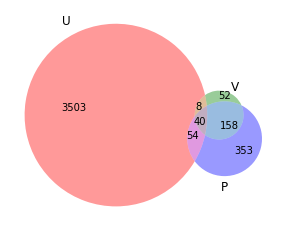

In [144]:
v = venn3([U, V, P], set_labels = ('U', 'V', 'P'), )

/home/laura/env36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/home/laura/env36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn3()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"
/home/laura/env36/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


<Figure size 720x360 with 0 Axes>

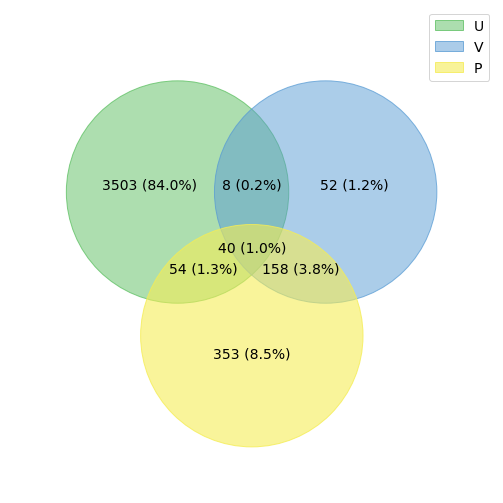

In [145]:
plt.figure(figsize=(10,5))
alpha = 0.2

labels = venn.get_labels([U, V, P], fill=['number',  'percent'] ) #'logic',
fig, ax = venn.venn3(labels, names=['U', 'V', 'P'])
fig.show()

# Check Gene is reverse

## Apply reverse if Gene is reverse

In [36]:
for i in vcf_res_df.index:
    alt_nucleotyde = vcf_res_df.loc[i, "ALT"]
    if vcf_res_df.loc[i, "Isreverse"] == True:
        vcf_res_df.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
    elif vcf_res_df.loc[i, "Isreverse"] == False:
        vcf_res_df.loc[i,'ALT2'] = alt_nucleotyde
        
for i in phyres_df.index:
    alt_nucleotyde = phyres_df.loc[i, "ALT"]
    if phyres_df.loc[i, "Isreverse"] == True:
        phyres_df.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
    elif phyres_df.loc[i, "Isreverse"] == False:
        phyres_df.loc[i,'ALT2'] = alt_nucleotyde
        
for i in ultra_df_og.index:
    alt_nucleotyde = ultra_df_og.loc[i, "ALT"]
    if ultra_df_og.loc[i, "Isreverse"] == True:
        ultra_df_og.loc[i,'ALT2'] = get_reverse(alt_nucleotyde)
    elif ultra_df_og.loc[i, "Isreverse"] == False:
        ultra_df_og.loc[i,'ALT2'] = alt_nucleotyde

# CREATE DICTIONARY

In [29]:
vcf_res_df.head()

,#CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,REG,SVTYPE,GENE,AMINO,RES,Gene ID,Gene name,Gene start,Gene stop,Isreverse,POSALT,ALT2
0,MTB_anc,6575,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485Cys,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6575T,T
1,MTB_anc,6576,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Arg485His,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6576A,A
2,MTB_anc,6579,.,C,T,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Phe,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6579T,T
3,MTB_anc,6579,.,C,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Ser486Tyr,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6579A,A
4,MTB_anc,6620,.,G,A,.,.,REG=coding;SVTYPE=SNP;GENE=Rv0005:gyrB:5123:72...,coding,SNP,Rv0005:gyrB:5123:7267,Asp500Asn,fluoroquinolones_(FQ),Rv0005,gyrB,5123,7267,False,6620A,A


In [42]:
phyres_df.head()

,POS,Variant position genome stop,Var. type,Number,WT base,Var. base,Region,Gene ID,Gene Name,Gene start,Gene stop,Gene length,Dir.,WT AA,Codon nr.,Codon nr. E. coli,Var. AA,AA change,Codon change,Variant position gene start,Variant position gene stop,Antibiotic,Reference PMID,High Confidence SNP,ALT,REF,POSALT,Isreverse,ALT2
0,6575,6575,SNP,1,c,t,coding,Rv0005,gyrB,5240,7267,2028,+,Arg,446,-,Cys,Arg446Cys,cgt/tgt,1336,1336,fluoroquinolones (FQ),19470506,no,T,C,6575T,False,T
1,6620,6620,SNP,1,g,c,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,His,Asp461His,gac/cac,1381,1381,fluoroquinolones (FQ),24055765,yes,C,G,6620C,False,C
2,6620,6620,SNP,1,g,a,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,Asn,Asp461Asn,gac/aac,1381,1381,fluoroquinolones (FQ),19721073,yes,A,G,6620A,False,A
3,6621,6621,SNP,1,a,c,coding,Rv0005,gyrB,5240,7267,2028,+,Asp,461,-,Ala,Asp461Ala,gac/gcc,1382,1382,fluoroquinolones (FQ),24055765,yes,C,A,6621C,False,C
4,6734,6734,SNP,1,a,g,coding,Rv0005,gyrB,5240,7267,2028,+,Asn,499,-,Asp,Asn499Asp,aac/gac,1495,1495,fluoroquinolones (FQ),17412727,yes,G,A,6734G,False,G


In [50]:
ultra_df_og.confidence_upp = ultra_df_og.confidence_upp.astype(str)

In [54]:
ultra_df_og_inf = ultra_df_og[(ultra_df_og.confidence_upp == 'inf')]

# Remove nonSNPs

In [53]:
ultra_df_og_inf = ultra_df_og[ultra_df_og.ALT.str.len() == 1]

# Now create dictionary

In [55]:
list_res_position = []
dict_res_position_base = {}
for index in ultra_df_og_inf.index:
    position = ultra_df_og.loc[index,'POS']
    nucleotide = ultra_df_og.loc[index,'ALT2']
    resistance = ultra_df_og.loc[index,'drug']
    if position in list_res_position:
        list_value_res = dict_res_position_base[position]
        if nucleotide not in list_value_res[1:]:
            list_value_res.append(nucleotide)
            dict_res_position_base[position] = list_value_res
    else:
        list_res_position.append(position)
        dict_res_position_base[position] = [resistance, nucleotide]
    #print(position, nucleotide, resistance)
for index in phyres_df.index:
    position = phyres_df.loc[index,'POS']
    nucleotide = phyres_df.loc[index,'ALT2']
    resistance = phyres_df.loc[index,'Antibiotic']
    if position in list_res_position:
        list_value_res = dict_res_position_base[position]
        if nucleotide not in list_value_res[1:]:
            list_value_res.append(nucleotide)
            dict_res_position_base[position] = list_value_res
    else:
        list_res_position.append(position)
        dict_res_position_base[position] = [resistance, nucleotide]

for index in vcf_res_df.index:
    position = vcf_res_df.loc[index,'POS']
    nucleotide = vcf_res_df.loc[index,'ALT2']
    resistance = vcf_res_df.loc[index,'RES']
    if position in list_res_position:
        list_value_res = dict_res_position_base[position]
        if nucleotide not in list_value_res[1:]:
            list_value_res.append(nucleotide)
            dict_res_position_base[position] = list_value_res
    else:
        list_res_position.append(position)
        dict_res_position_base[position] = [resistance, nucleotide]


In [56]:
print(dict_res_position_base)

{1472895: ['AMIKACIN', 'T'], 1473035: ['AMIKACIN', 'A'], 1473068: ['AMIKACIN', 'G'], 1473080: ['AMIKACIN', 'A'], 1473191: ['AMIKACIN', 'T'], 1473246: ['AMIKACIN', 'G'], 1473247: ['AMIKACIN', 'T'], 1473329: ['AMIKACIN', 'T'], 1472000: ['AMIKACIN', 'GAAAA'], 1472016: ['AMIKACIN', 'T'], 1472127: ['AMIKACIN', 'T'], 1472129: ['AMIKACIN', 'C'], 1472137: ['AMIKACIN', 'A'], 1472150: ['AMIKACIN', 'A'], 1472151: ['AMIKACIN', 'T'], 1472172: ['AMIKACIN', 'C'], 1472203: ['AMIKACIN', 'A'], 1472210: ['AMIKACIN', 'C'], 1472213: ['AMIKACIN', 'C'], 1472225: ['AMIKACIN', 'A'], 1472236: ['AMIKACIN', 'G'], 1472240: ['AMIKACIN', 'A'], 1472359: ['AMIKACIN', 'C', 'T'], 1472400: ['AMIKACIN', 'T'], 1472517: ['AMIKACIN', 'A'], 1472518: ['AMIKACIN', 'A'], 1472530: ['AMIKACIN', 'A'], 1472557: ['AMIKACIN', 'A'], 1472598: ['AMIKACIN', 'C'], 1472616: ['AMIKACIN', 'A'], 1472713: ['AMIKACIN', 'C'], 1472716: ['AMIKACIN', 'T'], 1472734: ['AMIKACIN', 'T'], 1472741: ['AMIKACIN', 'A'], 1472744: ['AMIKACIN', 'G'], 1472750: [

## Save dictionary into a file and remove lineage positions

In [57]:
with open ('dict_position_resistance_v2_inf.txt', 'w+') as f:
    for k, v in dict_res_position_base.items():
        if not v[0].startswith('phylo'):
            line = str(k).strip() + ":" + ",".join(v) + "\n"
            #print(line)
            f.write(line)
        

In [200]:
dict_res_v2_test = {}
with open ('dict_position_resistance_v2.txt', 'r') as f:
    for line in f:
        dict_res_v2_test[line.split(":")[0]] = line.split(":")[1].strip().split(",")

In [201]:
dict_res_v2_test

{'1472895': ['AMIKACIN', 'T'],
 '1472970': ['AMIKACIN', 'T'],
 '1472993': ['AMIKACIN', 'A'],
 '1473035': ['AMIKACIN', 'A'],
 '1473068': ['AMIKACIN', 'G'],
 '1473080': ['AMIKACIN', 'A'],
 '1473082': ['AMIKACIN', 'A'],
 '1473084': ['AMIKACIN', 'C'],
 '1471969': ['AMIKACIN', 'C'],
 '1473106': ['AMIKACIN', 'G'],
 '1473122': ['AMIKACIN', 'A'],
 '1473129': ['AMIKACIN', 'T'],
 '1473177': ['AMIKACIN', 'A'],
 '1473179': ['AMIKACIN', 'T'],
 '1473191': ['AMIKACIN', 'T'],
 '1473192': ['AMIKACIN', 'G'],
 '1473226': ['AMIKACIN', 'T'],
 '1473246': ['AMIKACIN', 'G'],
 '1473247': ['AMIKACIN', 'T'],
 '1473254': ['AMIKACIN', 'G'],
 '1471987': ['AMIKACIN', 'A'],
 '1473288': ['AMIKACIN', 'G'],
 '1473329': ['AMIKACIN', 'T'],
 '1473352': ['AMIKACIN', 'T'],
 '1471861': ['AMIKACIN', 'A'],
 '1472016': ['AMIKACIN', 'T'],
 '1471862': ['AMIKACIN', 'G'],
 '1472058': ['AMIKACIN', 'G'],
 '1472123': ['AMIKACIN', 'T'],
 '1472127': ['AMIKACIN', 'T'],
 '1472129': ['AMIKACIN', 'C'],
 '1472132': ['AMIKACIN', 'G'],
 '147213

# Shorter dictionary for high confidence SNP (Needs to be updated)

In [174]:
dict_res_position_confidence = {}
for index in phyres_df.index:
    position = phyres_df.loc[index,'POS']
    nucleotide = phyres_df.loc[index,'ALT2']
    #'High Confidence SNP'

    if phyres_df.loc[index,'High Confidence SNP'] == "yes":
        dict_res_position_confidence[position] = nucleotide

In [175]:
print(dict_res_position_confidence)

{6620: 'A', 6621: 'C', 6734: 'G', 6735: 'C', 6736: 'G', 6737: 'C', 6738: 'A', 6741: 'T', 6742: 'T', 6750: 'T', 7563: 'T', 7564: 'C', 7570: 'T', 7572: 'C', 7581: 'T', 7582: 'C', 760314: 'T', 761101: 'T', 761109: 'T', 761110: 'T', 761139: 'T', 761140: 'G', 761155: 'T', 761161: 'C', 761277: 'T', 781687: 'G', 781822: 'G', 1473246: 'G', 1473247: 'T', 1473329: 'T', 1673425: 'T', 1673432: 'C', 1674481: 'G', 2155168: 'A', 2155169: 'C', 2155214: 'C', 2155289: 'G', 2288683: 'G', 2288697: 'G', 2288703: 'C', 2288718: 'G', 2288719: 'C', 2288740: 'G', 2288752: 'G', 2288754: 'G', 2288761: 'G', 2288764: 'G', 2288772: 'C', 2288778: 'C', 2288779: 'T', 2288805: 'A', 2288806: 'G', 2288817: 'A', 2288818: 'C', 2288823: 'G', 2288826: 'C', 2288827: 'G', 2288828: 'C', 2288830: 'G', 2288832: 'G', 2288833: 'C', 2288838: 'T', 2288839: 'G', 2288841: 'A', 2288847: 'T', 2288848: 'A', 2288853: 'C', 2288857: 'A', 2288868: 'C', 2288869: 'A', 2288874: 'G', 2288880: 'G', 2288883: 'G', 2288886: 'T', 2288887: 'C', 2288895: